In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [2]:
# Load cleaned dataset
df = pd.read_csv("liar_cleaned.csv")
df.head()

,label,statement,subject,speaker,speaker_job,state,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire_count,context,binary_label
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,1
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,1
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,Unknown,Unknown,none,7.0,19.0,3.0,5.0,44.0,a news release,0
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,Unknown,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,1


In [3]:
# Define features (statements) and labels
texts = df["statement"]
labels = df["binary_label"]

# Convert text data into numerical format using TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(texts)
y = labels

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train three models: Naïve Bayes, Logistic Regression, and Random Forest
models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

In [4]:
# Store results
model_results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    model_results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("\n")

Training Naïve Bayes...
Naïve Bayes Accuracy: 0.6126
              precision    recall  f1-score   support

           0       0.56      0.41      0.48      1095
           1       0.63      0.76      0.69      1463

    accuracy                           0.61      2558
   macro avg       0.60      0.59      0.58      2558
weighted avg       0.60      0.61      0.60      2558



Training Logistic Regression...
Logistic Regression Accuracy: 0.6224
              precision    recall  f1-score   support

           0       0.57      0.48      0.52      1095
           1       0.65      0.73      0.69      1463

    accuracy                           0.62      2558
   macro avg       0.61      0.61      0.61      2558
weighted avg       0.62      0.62      0.62      2558



Training Random Forest...
Random Forest Accuracy: 0.6220
              precision    recall  f1-score   support

           0       0.57      0.45      0.51      1095
           1       0.65      0.75      0.69      1463


In [5]:
# Select best model based on accuracy
best_model_name = max(model_results, key=model_results.get)
best_model = models[best_model_name]
print(f"Best Model: {best_model_name} with accuracy {model_results[best_model_name]:.4f}")

Best Model: Logistic Regression with accuracy 0.6224


In [8]:
# Save the best model and vectorizer for future use
joblib.dump(best_model, "best_fake_news_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

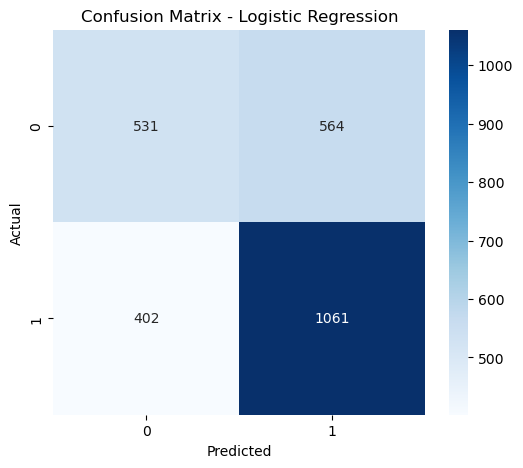

In [9]:
# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, best_model.predict(X_test)), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()